In [1]:
%matplotlib inline
import pylab as plt
import seaborn as sns
sns.set()
import pandas as pd
import numpy as np

In [87]:
def sigmoid(x, x0=0, l=1, scale=1):
    return scale / (1 + np.exp(-l * (x - x0)))

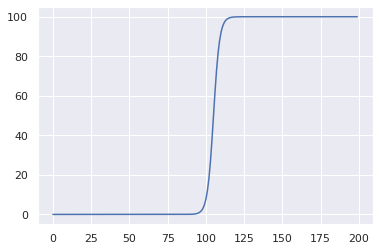

In [89]:
plt.plot(sigmoid(np.array(range(-100, 100)), 5, 0.5))

## CoVid Data
Taken from
https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv

#### Infected data

In [32]:
covid_data = pd.read_csv("corona_2020_03_18.csv", header=0)

covid_nonchina = covid_data[covid_data["Country/Region"] != "China"]

total_numbers = [covid_nonchina[date_col].sum() for date_col in covid_nonchina.columns[4:]]
xx = list(range(len(total_numbers)))
dates = pd.to_datetime(covid_nonchina.columns[4:])

total_numbers_df = pd.DataFrame(data=total_numbers, columns=["infected"], index=dates)

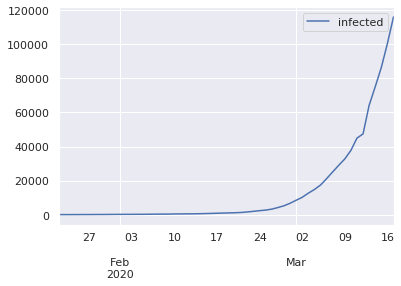

In [34]:
total_numbers_df.plot()

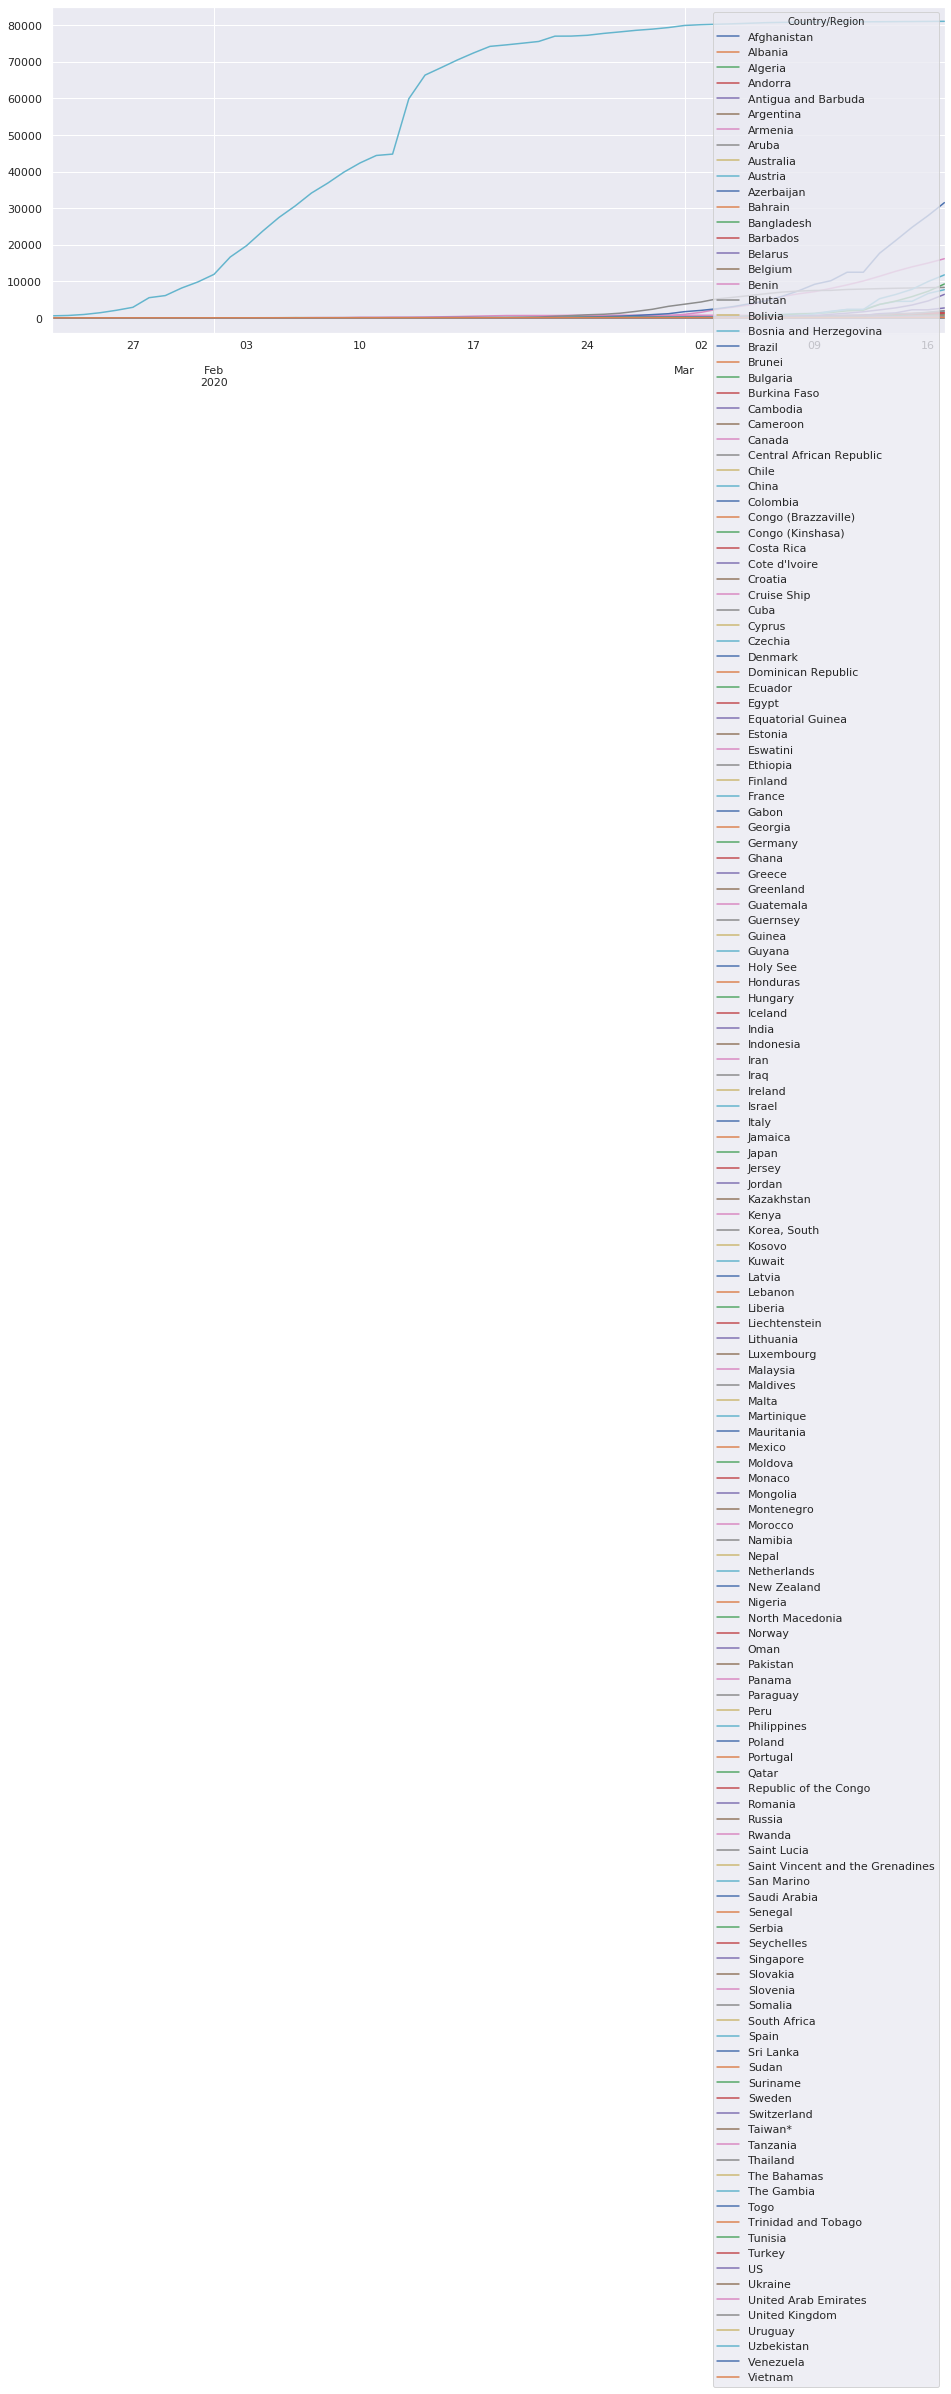

In [209]:
covid_data_by_country = covid_data.groupby("Country/Region").sum().transpose()[2:]
covid_data_by_country.index = pd.to_datetime(covid_data_by_country.index)
covid_data_by_country.plot(figsize=(16, 6))

#### Only Germany

In [197]:
covid_germany = covid_data[covid_data["Country/Region"] == "Germany"]

total_numbers_germany = [covid_germany[date_col].sum() for date_col in covid_germany.columns[4:]]

total_numbers_germany_df = pd.DataFrame(data=total_numbers_germany, columns=["infected"], index=dates)

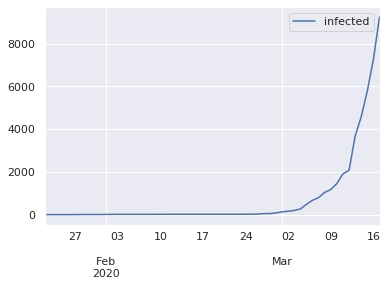

In [196]:
total_numbers_germany_df.plot()

## Fit Sigmoid to current numbers

In [154]:
popt, pcov = curve_fit(f=sigmoid, xdata=xx, ydata=total_numbers)

popt, pcov

(array([6.59152934e+01, 1.72423539e-01, 8.82238144e+05]),
 array([[ 7.34308132e+00, -1.20803900e-02,  8.78563241e+05],
        [-1.20803900e-02,  2.17950230e-05, -1.42444488e+03],
        [ 8.78563241e+05, -1.42444488e+03,  1.05359493e+11]]))

In [158]:
sigmoid_fit = pd.DataFrame(data=sigmoid(xx, *popt), index=total_numbers_df.index, columns=["sigmoid"])

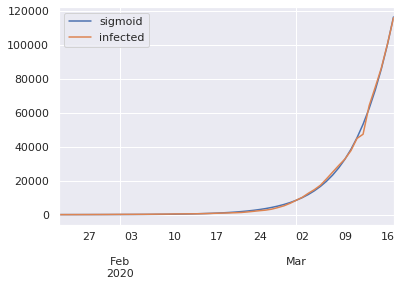

In [159]:
sigmoid_fit.join(total_numbers_df).plot()

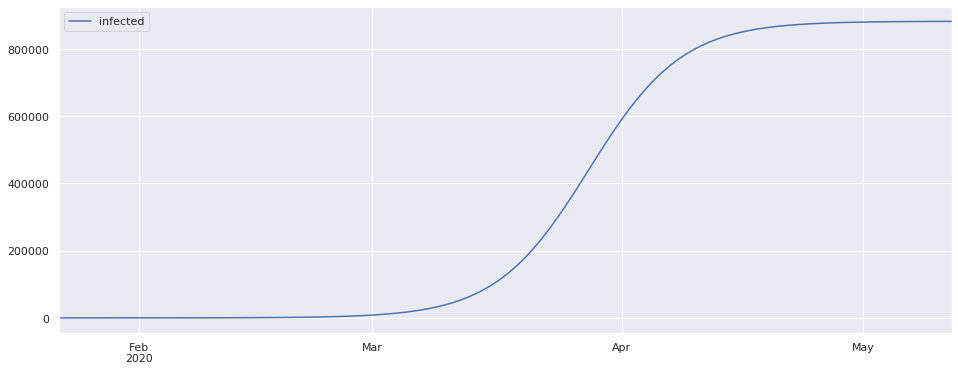

In [194]:
periods = 2 * len(total_numbers)
predicted_cases_sigmoid = pd.DataFrame(columns=["infected"], data=sigmoid(np.arange(0, periods), *popt), index=pd.date_range(start=total_numbers_df.index[0], periods=periods, freq="1d"))

predicted_cases_sigmoid.plot(figsize=(16, 6))

Let's assume that people get well again after about 4 weeks.

In [191]:
predicted_recoveries_sigmoid = pd.DataFrame(columns=["recovered"], data=predicted_cases_sigmoid.values, index=predicted_cases_sigmoid.index + pd.Timedelta(days=28))

predicted_recoveries_sigmoid

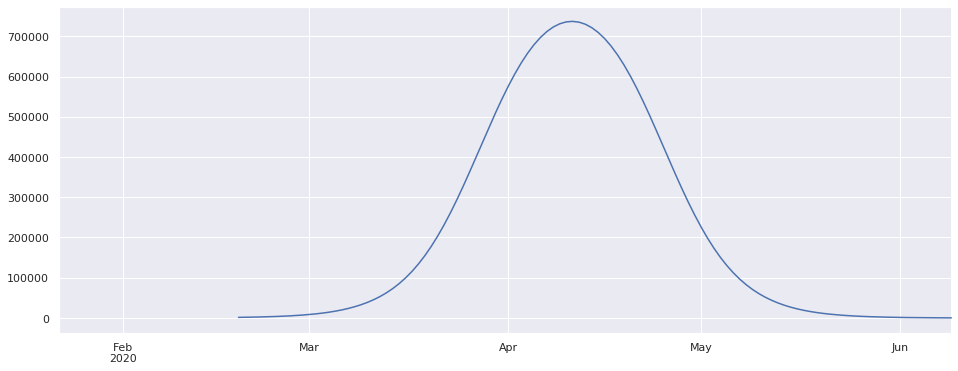

In [213]:
joiny = predicted_cases_sigmoid.join(predicted_recoveries_sigmoid, how="outer").ffill()
(joiny["infected"] - joiny["recovered"]).plot(figsize=(16, 6))

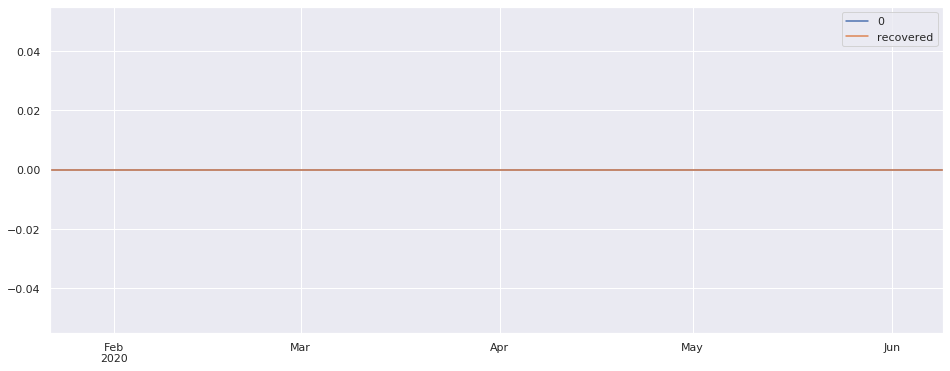

## Fit exp to current numbers

In [210]:
def exp(x, base=2, offset=0):
    return base ** (np.array(x) - offset)

In [151]:
popt, pcov = curve_fit(f=exp, xdata=xx, ydata=total_numbers, p0=(3.5, -27))

popt, pcov

(array([  1.17512793, -17.36297718]), array([[3.33017025e-06, 1.22464118e-03],
        [1.22464118e-03, 4.51232412e-01]]))

-152.89907002492808


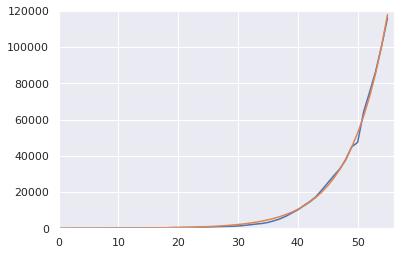

In [152]:
my_exp_fit = exp(xx, *popt)
plt.plot(total_numbers)
plt.plot(my_exp_fit)
plt.ylim((0, 120000))
plt.xlim((0, len(total_numbers)))
print(np.mean(np.array(total_numbers) - my_exp_fit))